In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.distributions import Categorical, Normal, Multinomial, Binomial, MultivariateNormal, Beta, constraints
from pyro.distributions.torch import Bernoulli
import pyro.infer as infer
from pyro.infer import TraceEnum_ELBO, Trace_ELBO, config_enumerate, SVI
from pyro import poutine

plt.style.use('seaborn-v0_8')

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pyro.set_rng_seed(1000)
torch.manual_seed(555450)
k = 3
d = 2
locs = torch.tensor([(1, 12), (-15, -10),  (32.5, 27.8)]).type(torch.FloatTensor)
scales = [torch.block_diag(torch.tensor([5]), torch.tensor([3.25])),
          torch.block_diag(torch.tensor([1.75]), torch.tensor([4.75])),
          torch.block_diag(torch.tensor([1]), torch.tensor([0.5])),
          
          ]

weights = torch.tensor([0.38, 0.22, 0.4])
gauss_dists = [dist.MultivariateNormal(loc, scales[i]) for i, loc in enumerate(locs.unbind())]
indices = [d for d in torch.multinomial(weights, 1000, replacement=True)]
data = [ gauss_dists[d].sample() for d in indices]

In [3]:
X, Y = torch.meshgrid(torch.arange(-20, 40, 0.4), 
                      torch.arange(-20, 40, 0.4)
                      )
X

/env_nlp/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[-20.0000, -20.0000, -20.0000,  ..., -20.0000, -20.0000, -20.0000],
        [-19.6000, -19.6000, -19.6000,  ..., -19.6000, -19.6000, -19.6000],
        [-19.2000, -19.2000, -19.2000,  ..., -19.2000, -19.2000, -19.2000],
        ...,
        [ 38.8000,  38.8000,  38.8000,  ...,  38.8000,  38.8000,  38.8000],
        [ 39.2000,  39.2000,  39.2000,  ...,  39.2000,  39.2000,  39.2000],
        [ 39.6000,  39.6000,  39.6000,  ...,  39.6000,  39.6000,  39.6000]])

In [4]:
Y

tensor([[-20.0000, -19.6000, -19.2000,  ...,  38.8000,  39.2000,  39.6000],
        [-20.0000, -19.6000, -19.2000,  ...,  38.8000,  39.2000,  39.6000],
        [-20.0000, -19.6000, -19.2000,  ...,  38.8000,  39.2000,  39.6000],
        ...,
        [-20.0000, -19.6000, -19.2000,  ...,  38.8000,  39.2000,  39.6000],
        [-20.0000, -19.6000, -19.2000,  ...,  38.8000,  39.2000,  39.6000],
        [-20.0000, -19.6000, -19.2000,  ...,  38.8000,  39.2000,  39.6000]])

In [5]:
probs = gauss_dists[0].log_prob(torch.column_stack((X.flatten(), Y.flatten()))).exp().view(X.size())
probs.size()

torch.Size([150, 150])

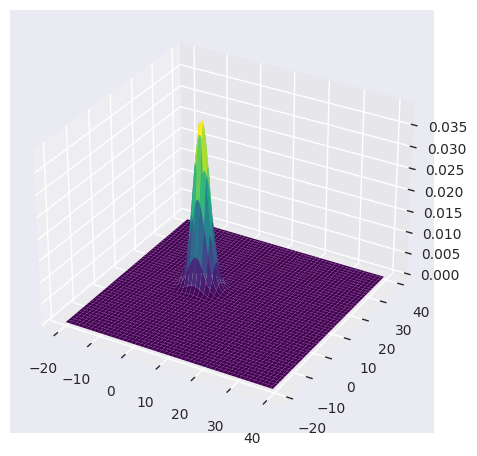

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, probs, cmap=plt.cm.viridis)

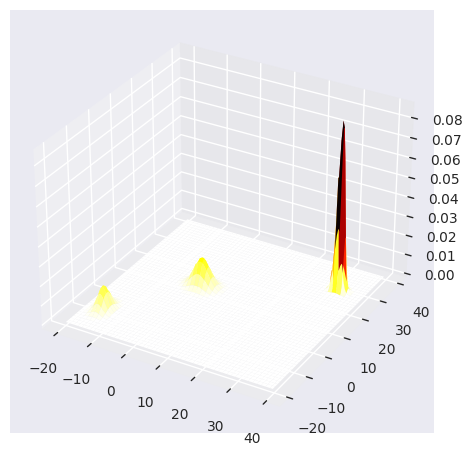

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X, Y = torch.meshgrid(torch.arange(-20, 40, 0.4), 
                      torch.arange(-20, 40, 0.4)
                      )
probs = 0.
for i in range(k):
    probs += weights[i] * gauss_dists[i].log_prob(torch.column_stack((X.flatten(), Y.flatten()))).exp().view(X.size())
ax.plot_surface(X, Y, probs, cmap=mpl.cm.hot_r)

In [8]:
test_data = torch.column_stack((X.flatten(), Y.flatten()))
test_data

tensor([[-20.0000, -20.0000],
        [-20.0000, -19.6000],
        [-20.0000, -19.2000],
        ...,
        [ 39.6000,  38.8000],
        [ 39.6000,  39.2000],
        [ 39.6000,  39.6000]])

In [9]:
X

tensor([[-20.0000, -20.0000, -20.0000,  ..., -20.0000, -20.0000, -20.0000],
        [-19.6000, -19.6000, -19.6000,  ..., -19.6000, -19.6000, -19.6000],
        [-19.2000, -19.2000, -19.2000,  ..., -19.2000, -19.2000, -19.2000],
        ...,
        [ 38.8000,  38.8000,  38.8000,  ...,  38.8000,  38.8000,  38.8000],
        [ 39.2000,  39.2000,  39.2000,  ...,  39.2000,  39.2000,  39.2000],
        [ 39.6000,  39.6000,  39.6000,  ...,  39.6000,  39.6000,  39.6000]])

In [10]:
data = torch.stack(data)

In [11]:
def model(data):
    w = pyro.sample("weights", dist.Dirichlet(torch.ones(k) / k))
    with pyro.plate("mix", k):
        sigma = pyro.sample("sigma", 
                            # dist.InverseGamma(torch.tensor([1.0, 1.0]), 
                            #                   torch.tensor([1.0] * 2)).to_event(1)
                            dist.LogNormal(0., 10.)
                            )
        mean = pyro.sample("mean", dist.Normal(0., torch.tensor([40.]*2)).to_event(1))
    with pyro.plate("data", len(data)):
        z = pyro.sample("z", dist.Categorical(w))
        return pyro.sample("obs", dist.Normal(mean[z], sigma[z].unsqueeze(1).tile(1, 2)).to_event(1),
                           obs=data)
       

In [12]:
pyro.clear_param_store()
guide = infer.autoguide.AutoDelta(poutine.block(model, expose=["weights", "sigma", "mean"]))
optimizer = pyro.optim.Adam({"lr": 1e-3})
svi = SVI(model, guide, optimizer, Trace_ELBO())

In [13]:
losses = []
for i in range(1000):
    losses.append(svi.step(data) / len(data))


/env_nlp/lib/python3.9/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'z'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


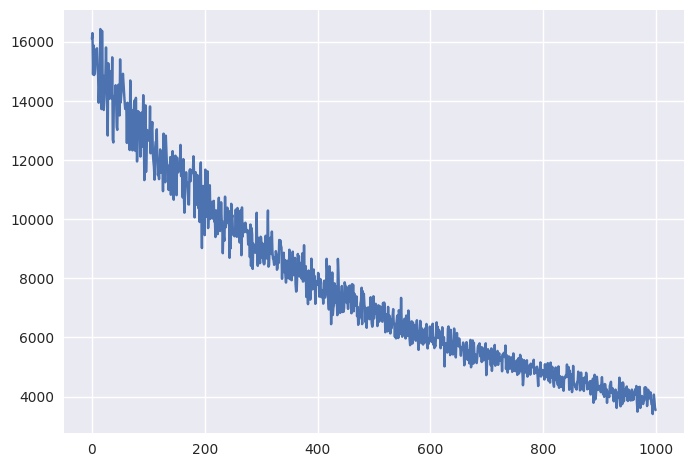

In [14]:
plt.plot(losses)

In [15]:
for p in pyro.get_param_store():
    print(p)

AutoDelta.weights
AutoDelta.sigma
AutoDelta.mean


In [16]:
weights

tensor([0.3800, 0.2200, 0.4000])

In [17]:
dist.Dirichlet(pyro.param("AutoDelta.weights")).sample()

tensor([0.3931, 0.6062, 0.0006])

In [18]:
locs

tensor([[  1.0000,  12.0000],
        [-15.0000, -10.0000],
        [ 32.5000,  27.8000]])

In [19]:
pyro.param("AutoDelta.mean")

Parameter containing:
tensor([[ 11.5800,   5.8337],
        [  8.3784,  -8.3185],
        [  2.9532, -19.1377]], requires_grad=True)

In [20]:
pyro.param("AutoDelta.sigma")

tensor([1.6968e-01, 3.6216e+00, 5.3219e+02], grad_fn=<AddBackward0>)

In [21]:
def get_params(guide):
    with torch.no_grad():
        est = guide(data)
    return est

get_params(guide)


{'weights': tensor([0.3490, 0.3122, 0.3388]),
 'sigma': tensor([1.6968e-01, 3.6216e+00, 5.3219e+02]),
 'mean': tensor([[ 11.5800,   5.8337],
         [  8.3784,  -8.3185],
         [  2.9532, -19.1377]], requires_grad=True)}

In [22]:
model_enum = config_enumerate(model)
trace = poutine.trace(poutine.enum(model_enum, first_available_dim=-2)).get_trace(data)

In [23]:
trace.compute_log_prob()

In [24]:
trace.format_shapes().split("\n")

['Trace Shapes:           ',
 ' Param Sites:           ',
 'Sample Sites:           ',
 ' weights dist        | 3',
 '        value        | 3',
 '     log_prob        |  ',
 '     mix dist        |  ',
 '        value      3 |  ',
 '     log_prob        |  ',
 '   sigma dist      3 |  ',
 '        value      3 |  ',
 '     log_prob      3 |  ',
 '    mean dist      3 | 2',
 '        value      3 | 2',
 '     log_prob      3 |  ',
 '    data dist        |  ',
 '        value   1000 |  ',
 '     log_prob        |  ',
 '       z dist   1000 |  ',
 '        value 3    1 |  ',
 '     log_prob 3 1000 |  ',
 '     obs dist 3 1000 | 2',
 '        value   1000 | 2',
 '     log_prob 3 1000 |  ']

In [25]:
pyro.clear_param_store()
guide = infer.autoguide.AutoDelta(poutine.block(model, expose=["weights", "sigma", "mean"]))
optimizer = pyro.optim.Adam({"lr": 1e-3})
svi = SVI(config_enumerate(model), guide, optimizer, TraceEnum_ELBO(max_plate_nesting=1))
losses = []
for i in range(10000):
    losses.append(svi.step(data) / len(data))

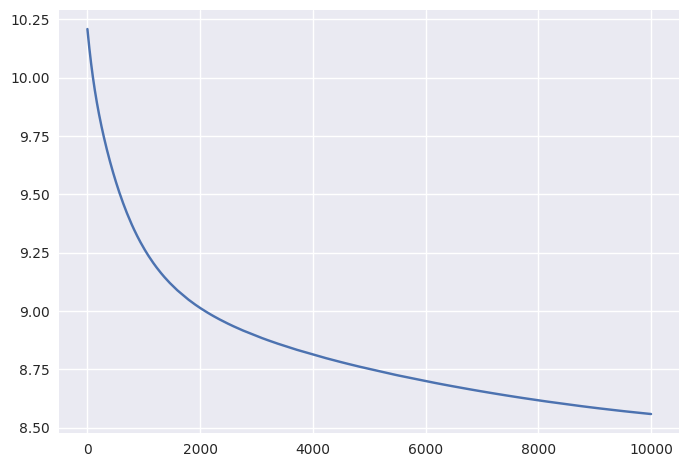

In [26]:
plt.plot(losses)

In [27]:
get_params(svi.guide), locs

({'weights': tensor([5.0459e-04, 5.0459e-04, 9.9899e-01]),
  'sigma': tensor([6.4292e-05, 1.3863e-04, 1.7314e+01]),
  'mean': tensor([[11.5914, 14.6406],
          [ 0.5754, -5.5022],
          [ 7.4825,  8.9944]], requires_grad=True)},
 tensor([[  1.0000,  12.0000],
         [-15.0000, -10.0000],
         [ 32.5000,  27.8000]]))

In [28]:
locs

tensor([[  1.0000,  12.0000],
        [-15.0000, -10.0000],
        [ 32.5000,  27.8000]])

In [37]:
def init_loc_fn(site):
    print(site["name"])
    if "weights" in site["name"]:
        value = torch.ones(k).float() / k
    
    if site["name"] in ["mean"]:
        # value = torch.tensor([[0.0] * 2] * k)
        # value = data[torch.multinomial(torch.ones(len(data)) / len(data), k)]
        value = torch.randn(k, 2)
    if site["name"] == "sigma":
        value = torch.ones(k)
    
    return value
    
pyro.clear_param_store()
pyro.set_rng_seed(55856)
model_enum = config_enumerate(model)
guide_list = infer.autoguide.AutoGuideList(poutine.block(model, expose=["weights", "sigma", "mean"]))
guide_list.append(infer.autoguide.AutoDelta(poutine.block(model, expose=["weights"], 
                                                          ),
                                            init_loc_fn=init_loc_fn
                                            )
                                
                                            )
guide_list.append(infer.autoguide.AutoNormal(poutine.block(model, 
                                                         expose=["sigma", "mean"],
                                                         ),
                                             init_loc_fn=init_loc_fn,
                                            init_scale=3.0
                                            ))
optimizer = pyro.optim.Adam({"lr": 3e-3})
svi = SVI(model_enum, guide_list, optimizer, TraceEnum_ELBO(max_plate_nesting=1))
losses = []
for i in range(200):
    losses.append(svi.step(data) / len(data))

weights
sigma
mean


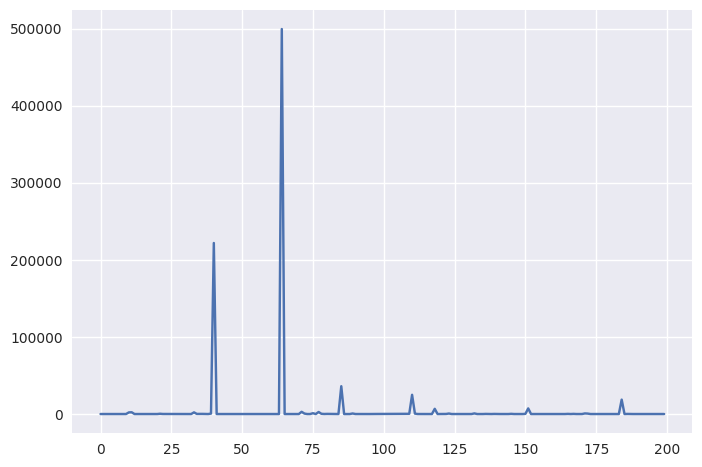

In [38]:
plt.plot(losses)

In [39]:
get_params(svi.guide)

{'weights': tensor([0.3346, 0.3238, 0.3416]),
 'sigma': tensor([0.1512, 0.0786, 0.0576]),
 'mean': tensor([[-3.8905, -2.5279],
         [ 3.1345, -1.3366],
         [-1.6164, -0.0967]])}

In [40]:
losses[100]

10.0376767578125

In [33]:
guide_trace = poutine.trace(svi.guide).get_trace(data)
trained_model = poutine.replay(svi.model, trace=guide_trace)

In [34]:
inf_model = infer.infer_discrete(trained_model, first_available_dim=-2)
trace = poutine.trace(inf_model).get_trace(data)

In [35]:
trace.nodes["z"]

{'type': 'sample',
 'name': 'z',
 'fn': Categorical(probs: torch.Size([1000, 3])),
 'is_observed': False,
 'args': (),
 'kwargs': {},
 'value': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [255]:
def model2(data):
    w = pyro.sample("weights", dist.Dirichlet(torch.ones(k) / k))
    with pyro.plate("mix", k):
        sigma = pyro.sample("sigma", 
                            dist.LogNormal(torch.tensor([1., 1.]), torch.tensor([1, 1])).to_event(1)
                            )
        mean = pyro.sample("mean", dist.Normal(0., torch.tensor([40.]*2)).to_event(1))
    with pyro.plate("data", len(data)):
        z = pyro.sample("z", dist.Categorical(w))
        return pyro.sample("obs", dist.Normal(mean[z], sigma[z]).to_event(1),
                           obs=data)

def guide2(data):
    pyro.sample("weights", 
                dist.Delta(pyro.param("wloc", lambda: torch.ones(k) / k,  constraint=constraints.simplex)).to_event(1)
            )
    
    pyro.sample("mean", 
                dist.Delta(pyro.param("meanloc", lambda: torch.randn(k, 2), )).to_event(1)
            )
    
    pyro.sample("sigma", 
                dist.Delta(pyro.param("sigmaloc", lambda: torch.ones(k, 2), constraint=constraints.positive),
                           ).to_event(1)
            )
    
    with pyro.plate("data", len(data)):
        z_loc = pyro.param("z_loc", lambda: torch.ones(len(data), k) / k,
                           constraint=constraints.simplex)
        z = pyro.sample("z", dist.Categorical(z_loc))
        # print(z)
    # z = pyro.sample("z", dist.Categorical(z_loc).to_event(1))


In [260]:
guide_trace = poutine.trace(guide2).get_trace(data)
trace = poutine.trace(poutine.replay(model2, trace=guide_trace)).get_trace(data)
trace

In [262]:
trace.compute_log_prob()

In [265]:
trace.format_shapes().split("\n")

['Trace Shapes:         ',
 ' Param Sites:         ',
 'Sample Sites:         ',
 ' weights dist      | 3',
 '        value      | 3',
 '     log_prob      |  ',
 '     mix dist      |  ',
 '        value    3 |  ',
 '     log_prob      |  ',
 '   sigma dist    3 | 2',
 '        value    3 | 2',
 '     log_prob    3 |  ',
 '    mean dist    3 | 2',
 '        value    3 | 2',
 '     log_prob    3 |  ',
 '    data dist      |  ',
 '        value 1000 |  ',
 '     log_prob      |  ',
 '       z dist 1000 |  ',
 '        value 1000 |  ',
 '     log_prob 1000 |  ',
 '     obs dist 1000 | 2',
 '        value 1000 | 2',
 '     log_prob 1000 |  ']

In [256]:
pyro.clear_param_store()
pyro.set_rng_seed(66666)

optimizer = pyro.optim.Adam({"lr": 3e-4})
# guide_list = infer.autoguide.AutoGuideList(poutine.block(model2, 
#                                                          expose=["weights", "sigma", "mean", "z"]))
# guide_list.append(
#     infer.autoguide.AutoNormal(poutine.block(model2, expose=["weights", "sigma", "mean"]))
# )
# guide_list.append(guide2)

# svi = SVI(model2, guide_list, optimizer, TraceEnum_ELBO(max_plate_nesting=1))
svi = SVI(model2, guide2, optimizer, Trace_ELBO())
losses = []


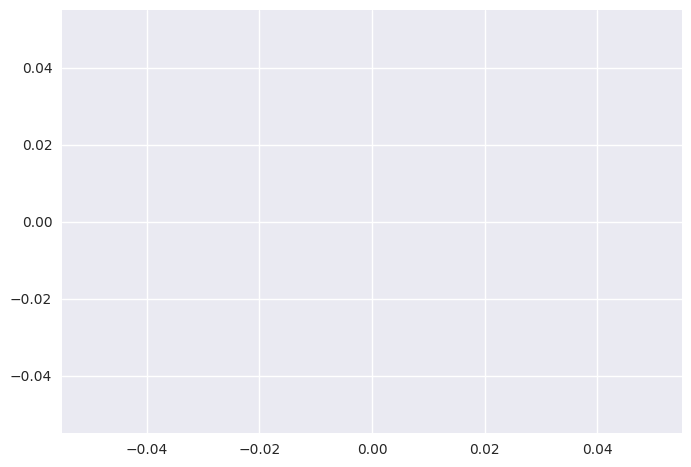

In [205]:
plt.plot(losses)

In [253]:
d = dist.LogNormal(torch.tensor([1., 1.]), torch.tensor([1, 1])).to_event(1)
d.sample()                 

tensor([11.2809,  0.1486])

In [254]:
d.log_prob(d.sample())

tensor(-3.2956)